# Background
- In linear regression we have the following conditions
    - $x_{ij} \subset (-\infty, \infty)$
    - $y_i \subset (-\infty, \infty)\$

- In Logistic regression however, we are predicting binary outcomes
    - $x_{ij} \subset (-\infty, \infty)$
    - $y_i \subset \[0, 1\]\$ (probability of an event between 0 and 1)

# Libraries | Install

In [1]:
!pip install torch sklearn numpy matplotlib tqdm torchviz ann_visualizer torchsummary tensorboard --quiet

You should consider upgrading via the '/Users/fermibot/PycharmProjects/python-projects/venv/bin/python -m pip install --upgrade pip' command.


# Libraries | Import

In [47]:
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from random import random, randint, choice, normalvariate
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchviz import make_dot
from torchsummary import summary
import pandas as pd

# Functions | Define

In [52]:
def randomize(factor):
    return choice([-1, 1]) * factor * random()


class Config:
    x_n = 2  # NUMBER OF INPUT VARIABLES
    lr = 0.01
    lrs = [0.01, 0.00001]
    epochs = 25
    split_train = 0.8
    shuffle = True
    batch_size = 64
    batch_sizes = [16, 64, 1024]
    device = torch.device("mps")
    size_x = 2 ** 14


def print_separator():
    print("\n" + "-" * 100)


config = Config()


def plot_custom(df_pandas, plot_label: str=''):
    ax = df_pandas.plot.scatter(x=0, y=1, c='y', figsize=(7, 7), colormap='viridis')

    # Set the aspect ratio to 1:1 (equal)
    ax.set_aspect('equal', adjustable='box')
    
    # Set labels for clarity
    ax.set_xlabel('Feature 0 ($x_1$)')
    ax.set_ylabel('Feature 1 ($x_2$)')
    
    plt.savefig(plot_label)
    plt.show()

def fit_custom(df_pandas, show_predicted=False):
    plot_custom(df_pandas)
    logistic = LogisticRegression()
    logistic.fit(df_pandas[['x1','x2']], df_pandas['y'])
    logistic_score = logistic.score(df_pandas[['x1', 'x2']], y)
    print("Accuracy", logistic_score)

    y_prob = logistic.predict_proba(df_pandas[['x1','x2']])[:, 1]
    auc_score = roc_auc_score(y, y_prob)
    print("AUC", auc_score)
    

    if show_predicted:
        df_predicted = df_pandas[['x1', 'x2']].copy()
        df_predicted['y'] = logistic.predict(df_predicted)
        plot_custom(df_predicted)


X = [[normalvariate() for j in range(config.x_n)] for x in range(config.size_x)]


# Dataset | Synthesize

$Y_j = \overset{2}{\underset{i=1}{\Sigma}} f_i(x_{ij}) \mid x_i \subset N(0, 1)$

## Logistic Regression | Dependency | Linear | $x_1$

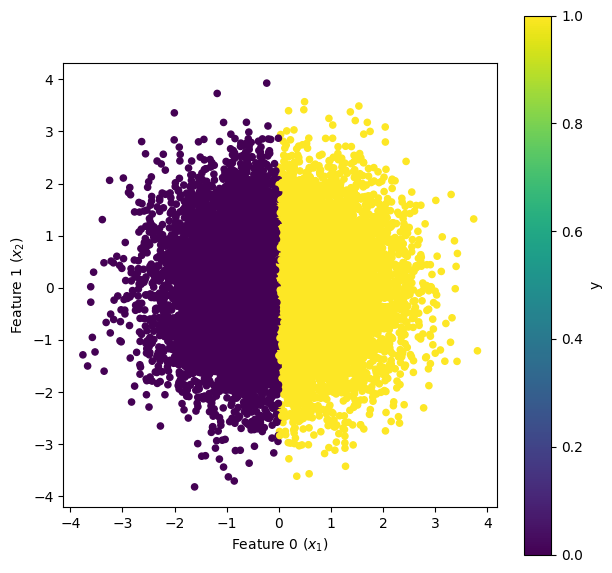

Accuracy 0.99945068359375
AUC 0.9999989716815862


In [53]:
y = [1 if x[0] > 0 else 0 for x in X]

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y

fit_custom(df, show_predicted=False)

## Logistic Regression | Dependency | Linear | $x_2$

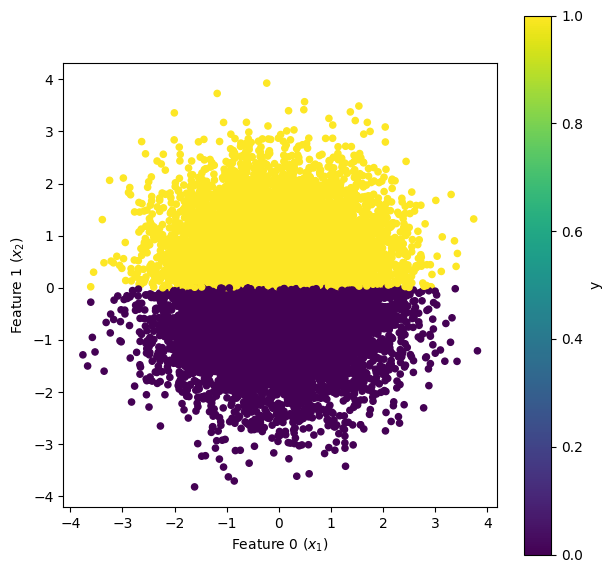

Accuracy 0.9986572265625
AUC 0.9999966021159608


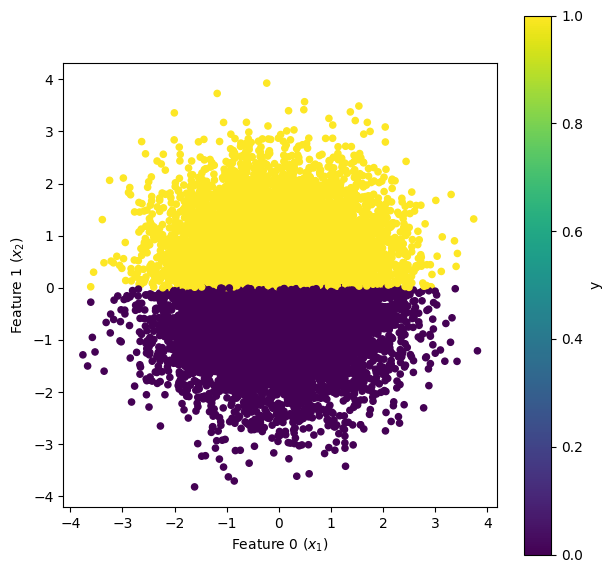

In [69]:
y = [1 if x[1] > 0 else 0 for x in X]

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y

fit_custom(df, show_predicted=True)

## Logistic Regression | Dependency | Linear | $x_1$ and $x_2$ | Version A

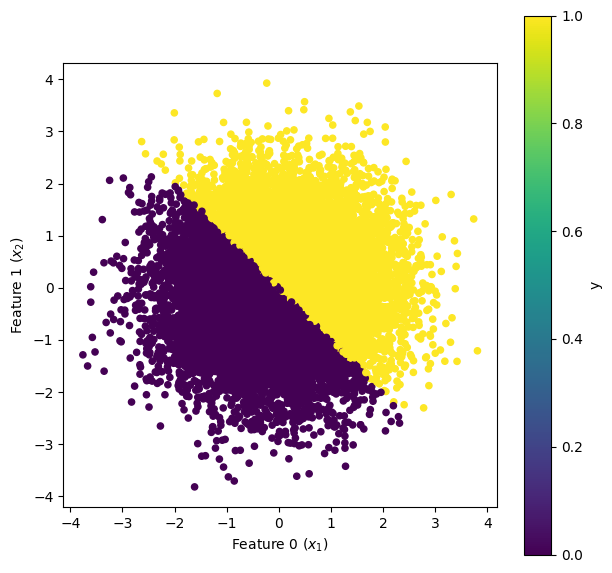

Accuracy 0.9989013671875
AUC 0.9999973773164907


In [59]:
y = [1 if x[0] + x[1] > 0 else 0 for x in X]

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y

fit_custom(df)

## Logistic Regression | Dependency | Linear | $x_1$ and $x_2$ | Version B

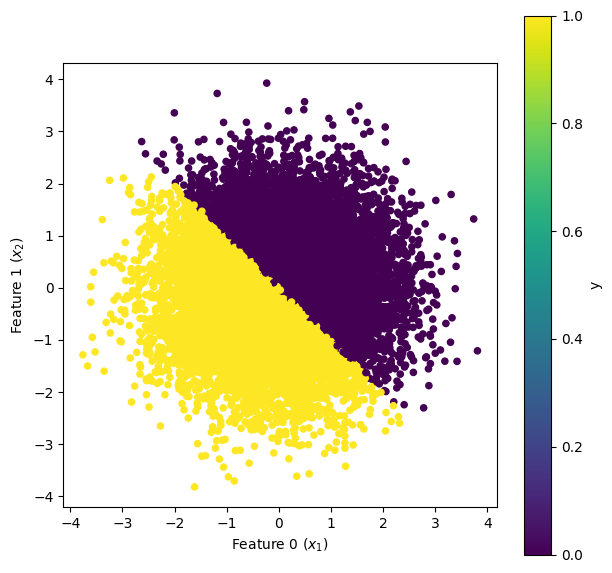

Accuracy 0.9989013671875
AUC 0.9999973773164909


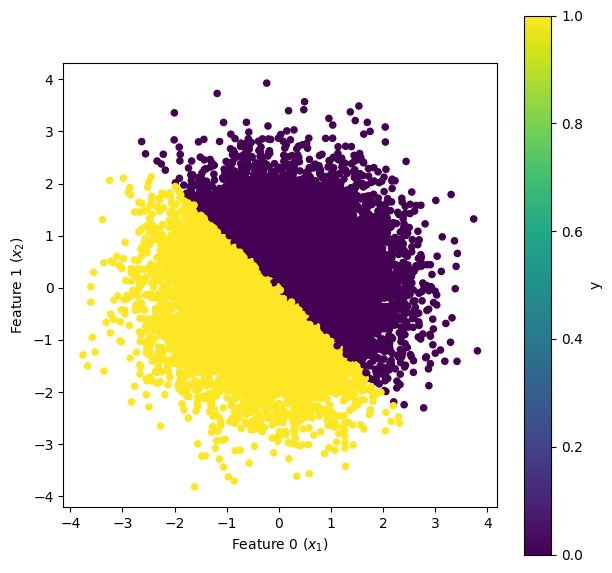

In [70]:
y = [1 if x[0] + x[1] < 0 else 0 for x in X]

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y

fit_custom(df, show_predicted=True)

## Logistic Regression | Dependency | Non Linear | $x_1$ and $x_2$

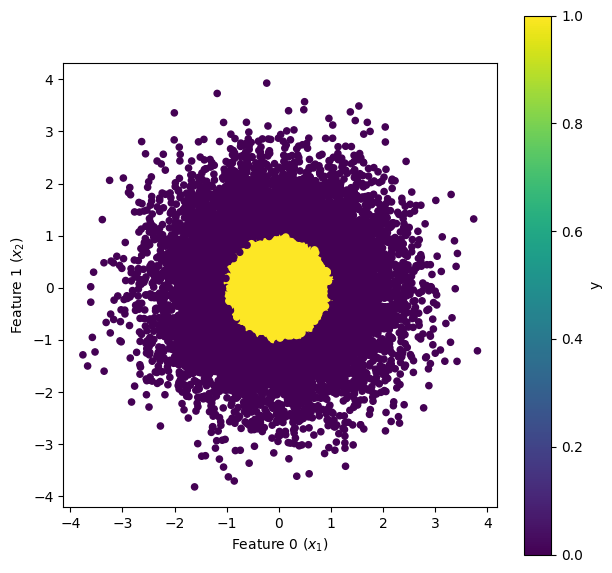

Accuracy 0.60888671875
AUC 0.5048483870652862


In [71]:
y = [1 if x[0] ** 2 + x[1] ** 2 < 1 else 0 for x in X]

df = pd.DataFrame(X, columns=['x1', 'x2'])
df['y'] = y

fit_custom(df)

## How is the model trying to predict? 
- Internally, the model is trying to fit to the equation $P(Y=1) = \frac{1}{1+e^-Z}$
- Where $Z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 ...$
- The model adjusts the coefficients $\beta_0, \beta_1, \beta_2, \beta_3 ...$
- Calculates the probability using the function $P(Y=1)$
- If the Probability is above 0.5 (threshold), then the model tried to 'move' in that direction
- By adjusting the $\beta s$, it arrives at the best possible fit

# Loss example

Update various slope values and observe how the loss changes.


| x1 | x2 | y |
| :- | :-: | -: |
| 0 | 0 | 0 |
| -1 | 1 | 1 |
| 3 | 2 | 1 |
| 4 | -1 | 0 |
| 5 | -2 | 0 |


In [81]:
import math
import numpy as np

data = [
    [0, 0, 0],
    [-1, 1, 1], 
    [3, 2, 1],
    [4, -1, 0],
    [5, -2, 0]
]

beta0 = 0
beta1 = 0
beta2 = 200

print("Initial coefficients:")
print(f"β₀ = {beta0:.3f}, β₁ = {beta1:.3f}, β₂ = {beta2:.3f}")

def sigmoid(z):
    return 1 / (1 + math.exp(-z))

def calculate_probability(x1, x2, b0, b1, b2):
    z = b0 + b1 * x1 + b2 * x2
    return sigmoid(z)

def calculate_loss(data, b0, b1, b2):
    total_loss = 0
    n = len(data)
    
    for row in data:
        x1, x2, y_actual = row
        p = calculate_probability(x1, x2, b0, b1, b2)
        
        # Log loss calculation
        if y_actual == 1:
            loss = -math.log(p) if p > 0 else float('inf')
        else:  # y_actual == 0
            loss = -math.log(1 - p) if p < 1 else float('inf')
            
        total_loss += loss
    
    return total_loss / n 

# Calculate initial loss
initial_loss = calculate_loss(data, beta0, beta1, beta2)
print(f"\nInitial loss: {initial_loss:.4f}")

# Show predictions and probabilities
print("\nInitial predictions:")
for i, (x1, x2, y_actual) in enumerate(data):
    p = calculate_probability(x1, x2, beta0, beta1, beta2)
    prediction = 1 if p > 0.5 else 0
    correct = "✓" if prediction == y_actual else "✗"
    print(f"Point {i+1}: x1={x1}, x2={x2}, y_actual={y_actual}, p={p:.4f}, pred={prediction} {correct}")

Initial coefficients:
β₀ = 0.000, β₁ = 0.000, β₂ = 200.000

Initial loss: 0.1386

Initial predictions:
Point 1: x1=0, x2=0, y_actual=0, p=0.5000, pred=0 ✓
Point 2: x1=-1, x2=1, y_actual=1, p=1.0000, pred=1 ✓
Point 3: x1=3, x2=2, y_actual=1, p=1.0000, pred=1 ✓
Point 4: x1=4, x2=-1, y_actual=0, p=0.0000, pred=0 ✓
Point 5: x1=5, x2=-2, y_actual=0, p=0.0000, pred=0 ✓


In [82]:
# Test different coefficient combinations
coefficient_sets = [
    {"beta0": 0, "beta1": 0.2, "beta2": 1},  # Initial
]

print("Testing Different Coefficient Combinations")


for i, coefs in enumerate(coefficient_sets):
    b0, b1, b2 = coefs["beta0"], coefs["beta1"], coefs["beta2"]
    loss = calculate_loss(data, b0, b1, b2)
    
    print(f"\nSet {i+1}: β₀ = {b0:.2f}, β₁ = {b1:.2f}, β₂ = {b2:.2f}")
    print(f"Loss: {loss:.4f}")
    
    # Show accuracy for this coefficient set
    correct = 0
    for x1, x2, y_actual in data:
        p = calculate_probability(x1, x2, b0, b1, b2)
        prediction = 1 if p > 0.5 else 0
        if prediction == y_actual:
            correct += 1
    
    accuracy = correct / len(data)
    print(f"Accuracy: {accuracy:.1%} ({correct}/{len(data)})")

Testing Different Coefficient Combinations

Set 1: β₀ = 0.00, β₁ = 0.20, β₂ = 1.00
Loss: 0.4095
Accuracy: 100.0% (5/5)
